# Heart Disease Prediction: Exploratory Data Analysis

This notebook explores the heart disease dataset to understand its characteristics, distributions, and potential patterns that could inform feature engineering and model selection.

## Project Overview

We propose a supervised classification project where the primary objective is to predict heart disease status (Yes/No) based on various patient health indicators. Specifically, we will use the patient's health and lifestyle features to predict Heart Disease Status, in order to identify individuals at risk and recommend early intervention or further diagnostic tests.

In [24]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# Add project root to path to import custom modules
sys.path.append('..')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

In [25]:
# Load project configuration
from src.config import RAW_DATA_PATH, TARGET_COLUMN, CATEGORICAL_FEATURES, NUMERICAL_FEATURES
from src.data.data_loader import load_data
from src.data.preprocessor import check_data_quality, clean_data

# Load the raw data
data = load_data(RAW_DATA_PATH)

# Display the first few rows
print(f"Dataset shape: {data.shape}")
data.head()

2025-03-31 11:03:23,853 - src.data.data_loader - INFO - Loading data from /Users/thefatblue/Projects/HeartGuard-ML/data/raw/heart_disease.csv
2025-03-31 11:03:24,051 - src.data.data_loader - INFO - Successfully loaded data with shape (10000, 21)


Dataset shape: (10000, 21)


,Age,Gender,Blood Pressure,Cholesterol Level,Exercise Habits,Smoking,Family Heart Disease,Diabetes,BMI,High Blood Pressure,Low HDL Cholesterol,High LDL Cholesterol,Alcohol Consumption,Stress Level,Sleep Hours,Sugar Consumption,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level,Heart Disease Status
0,56.0,Male,153.0,155.0,High,Yes,Yes,No,24.991591,Yes,Yes,No,High,Medium,7.633228,Medium,342.0,NaN,12.969246,12.387250,No
1,69.0,Female,146.0,286.0,High,No,Yes,Yes,25.221799,No,Yes,No,Medium,High,8.744034,Medium,133.0,157.0,9.355389,19.298875,No
2,46.0,Male,126.0,216.0,Low,No,No,No,29.855447,No,Yes,Yes,Low,Low,4.440440,Low,393.0,92.0,12.709873,11.230926,No
3,32.0,Female,122.0,293.0,High,Yes,Yes,No,24.130477,Yes,No,Yes,Low,High,5.249405,High,293.0,94.0,12.509046,5.961958,No
4,60.0,Male,166.0,242.0,Low,Yes,Yes,Yes,20.486289,Yes,No,No,Low,High,7.030971,High,263.0,154.0,10.381259,8.153887,No


## Data Overview

Let's examine the basic information about our dataset: data types, missing values, and summary statistics.

In [5]:
# Check data types
data.dtypes

Age                     float64
Gender                   object
Blood Pressure          float64
Cholesterol Level       float64
Exercise Habits          object
Smoking                  object
Family Heart Disease     object
Diabetes                 object
BMI                     float64
High Blood Pressure      object
Low HDL Cholesterol      object
High LDL Cholesterol     object
Alcohol Consumption      object
Stress Level             object
Sleep Hours             float64
Sugar Consumption        object
Triglyceride Level      float64
Fasting Blood Sugar     float64
CRP Level               float64
Homocysteine Level      float64
Heart Disease Status     object
dtype: object

In [6]:
# Check for missing values
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

# Show only columns with missing values
missing_df[missing_df['Missing Values'] > 0].sort_values('Percentage', ascending=False)

,Missing Values,Percentage
Alcohol Consumption,2586,25.86
Cholesterol Level,30,0.30
Diabetes,30,0.30
Sugar Consumption,30,0.30
Age,29,0.29
CRP Level,26,0.26
Triglyceride Level,26,0.26
High Blood Pressure,26,0.26
High LDL Cholesterol,26,0.26
Low HDL Cholesterol,25,0.25


In [7]:
# Check data quality with our custom function
quality_summary = check_data_quality(data)

# Check for duplicates
print(f"Number of duplicate rows: {quality_summary['duplicates']}")

2025-03-31 09:41:58,884 - src.data.preprocessor - INFO - Checking data quality
2025-03-31 09:41:59,000 - src.data.preprocessor - INFO - Data shape: (10000, 21)
2025-03-31 09:41:59,001 - src.data.preprocessor - INFO - Number of duplicates: 0
2025-03-31 09:41:59,003 - src.data.preprocessor - INFO - Columns with missing values: {'Age': 29, 'Gender': 19, 'Blood Pressure': 19, 'Cholesterol Level': 30, 'Exercise Habits': 25, 'Smoking': 25, 'Family Heart Disease': 21, 'Diabetes': 30, 'BMI': 22, 'High Blood Pressure': 26, 'Low HDL Cholesterol': 25, 'High LDL Cholesterol': 26, 'Alcohol Consumption': 2586, 'Stress Level': 22, 'Sleep Hours': 25, 'Sugar Consumption': 30, 'Triglyceride Level': 26, 'Fasting Blood Sugar': 22, 'CRP Level': 26, 'Homocysteine Level': 20}


Number of duplicate rows: 0


In [8]:
# Summary statistics for numerical features
data.describe()

,Age,Blood Pressure,Cholesterol Level,BMI,Sleep Hours,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level
count,9971.000000,9981.000000,9970.000000,9978.000000,9975.000000,9974.000000,9978.000000,9974.000000,9980.000000
mean,49.296259,149.757740,225.425577,29.077269,6.991329,250.734409,120.142213,7.472201,12.456271
std,18.193970,17.572969,43.575809,6.307098,1.753195,87.067226,23.584011,4.340248,4.323426
min,18.000000,120.000000,150.000000,18.002837,4.000605,100.000000,80.000000,0.003647,5.000236
25%,34.000000,134.000000,187.000000,23.658075,5.449866,176.000000,99.000000,3.674126,8.723334
50%,49.000000,150.000000,226.000000,29.079492,7.003252,250.000000,120.000000,7.472164,12.409395
75%,65.000000,165.000000,263.000000,34.520015,8.531577,326.000000,141.000000,11.255592,16.140564
max,80.000000,180.000000,300.000000,39.996954,9.999952,400.000000,160.000000,14.997087,19.999037


In [10]:
# Summary of categorical features
for col in CATEGORICAL_FEATURES:
    if col in data.columns:
        print(f"\n{col}:")
        value_counts = data[col].value_counts(dropna=False)
        percentage = value_counts / len(data) * 100
        summary = pd.DataFrame({'Count': value_counts, 'Percentage': percentage})
        print(summary)


Gender:
        Count  Percentage
Gender                   
Male     5003       50.03
Female   4978       49.78
NaN        19        0.19

Exercise Habits:
                 Count  Percentage
Exercise Habits                   
High              3372       33.72
Medium            3332       33.32
Low               3271       32.71
NaN                 25        0.25

Smoking:
         Count  Percentage
Smoking                   
Yes       5123       51.23
No        4852       48.52
NaN         25        0.25

Family Heart Disease:
                      Count  Percentage
Family Heart Disease                   
No                     5004       50.04
Yes                    4975       49.75
NaN                      21        0.21

Diabetes:
          Count  Percentage
Diabetes                   
No         5018       50.18
Yes        4952       49.52
NaN          30        0.30

High Blood Pressure:
                     Count  Percentage
High Blood Pressure                   
Yes           

## Target Variable Analysis

Let's examine the distribution of our target variable (Heart Disease Status) to understand the class imbalance.

In [11]:
# Class distribution
target_counts = data[TARGET_COLUMN].value_counts()
target_percent = 100 * target_counts / len(data)

# Create DataFrame for display
target_summary = pd.DataFrame({
    'Count': target_counts,
    'Percentage': target_percent
})

print("Heart Disease Status Distribution:")
target_summary

Heart Disease Status Distribution:


,Count,Percentage
Heart Disease Status,,
No,8000,80.0
Yes,2000,20.0


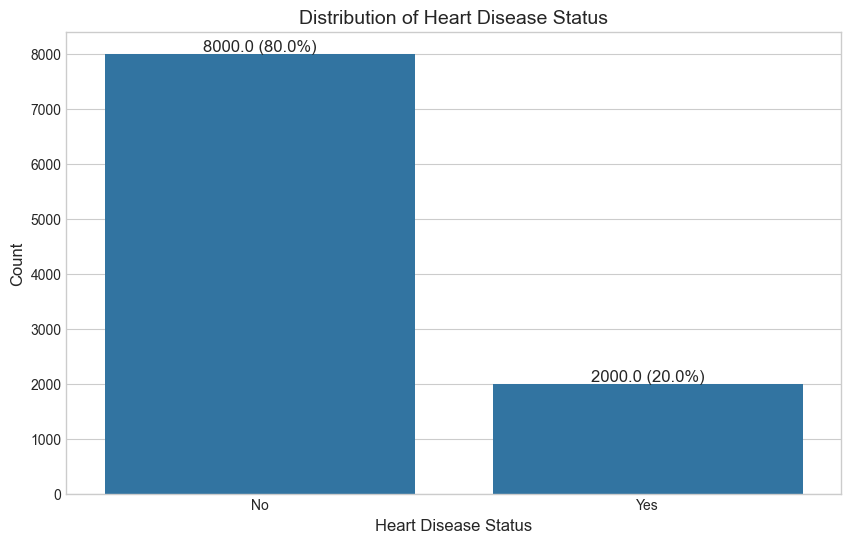

In [12]:
# Visualize target distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=TARGET_COLUMN, data=data)

# Add count and percentage labels
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 50,
            f'{height} ({target_percent.values[i]:.1f}%)',
            ha="center", fontsize=12)

plt.title('Distribution of Heart Disease Status', fontsize=14)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Heart Disease Status', fontsize=12)
plt.show()

## Feature Analysis

Now let's analyze the individual features and their relationship with the target variable.

In [13]:
# Clean the data before analysis
cleaned_data = clean_data(data)

# Confirm cleaning results
print(f"Original shape: {data.shape}, Cleaned shape: {cleaned_data.shape}")
print("\nMissing values after cleaning:")
print(cleaned_data.isnull().sum().sum())

2025-03-31 09:44:20,579 - src.data.preprocessor - INFO - Cleaning data
2025-03-31 09:44:20,636 - src.data.preprocessor - INFO - Converted target variable to binary (1/0)
2025-03-31 09:44:20,654 - src.data.preprocessor - INFO - Imputed missing values in 'Age' with median (49.0)
2025-03-31 09:44:20,659 - src.data.preprocessor - INFO - Imputed missing values in 'Blood Pressure' with median (150.0)
2025-03-31 09:44:20,668 - src.data.preprocessor - INFO - Imputed missing values in 'Cholesterol Level' with median (226.0)
2025-03-31 09:44:20,671 - src.data.preprocessor - INFO - Imputed missing values in 'BMI' with median (29.079491590086043)
2025-03-31 09:44:20,674 - src.data.preprocessor - INFO - Imputed missing values in 'Sleep Hours' with median (7.003252334814371)
2025-03-31 09:44:20,681 - src.data.preprocessor - INFO - Imputed missing values in 'Triglyceride Level' with median (250.0)
2025-03-31 09:44:20,684 - src.data.preprocessor - INFO - Imputed missing values in 'Fasting Blood Sugar'

Original shape: (10000, 21), Cleaned shape: (10000, 21)

Missing values after cleaning:
2835


### Numerical Features Analysis

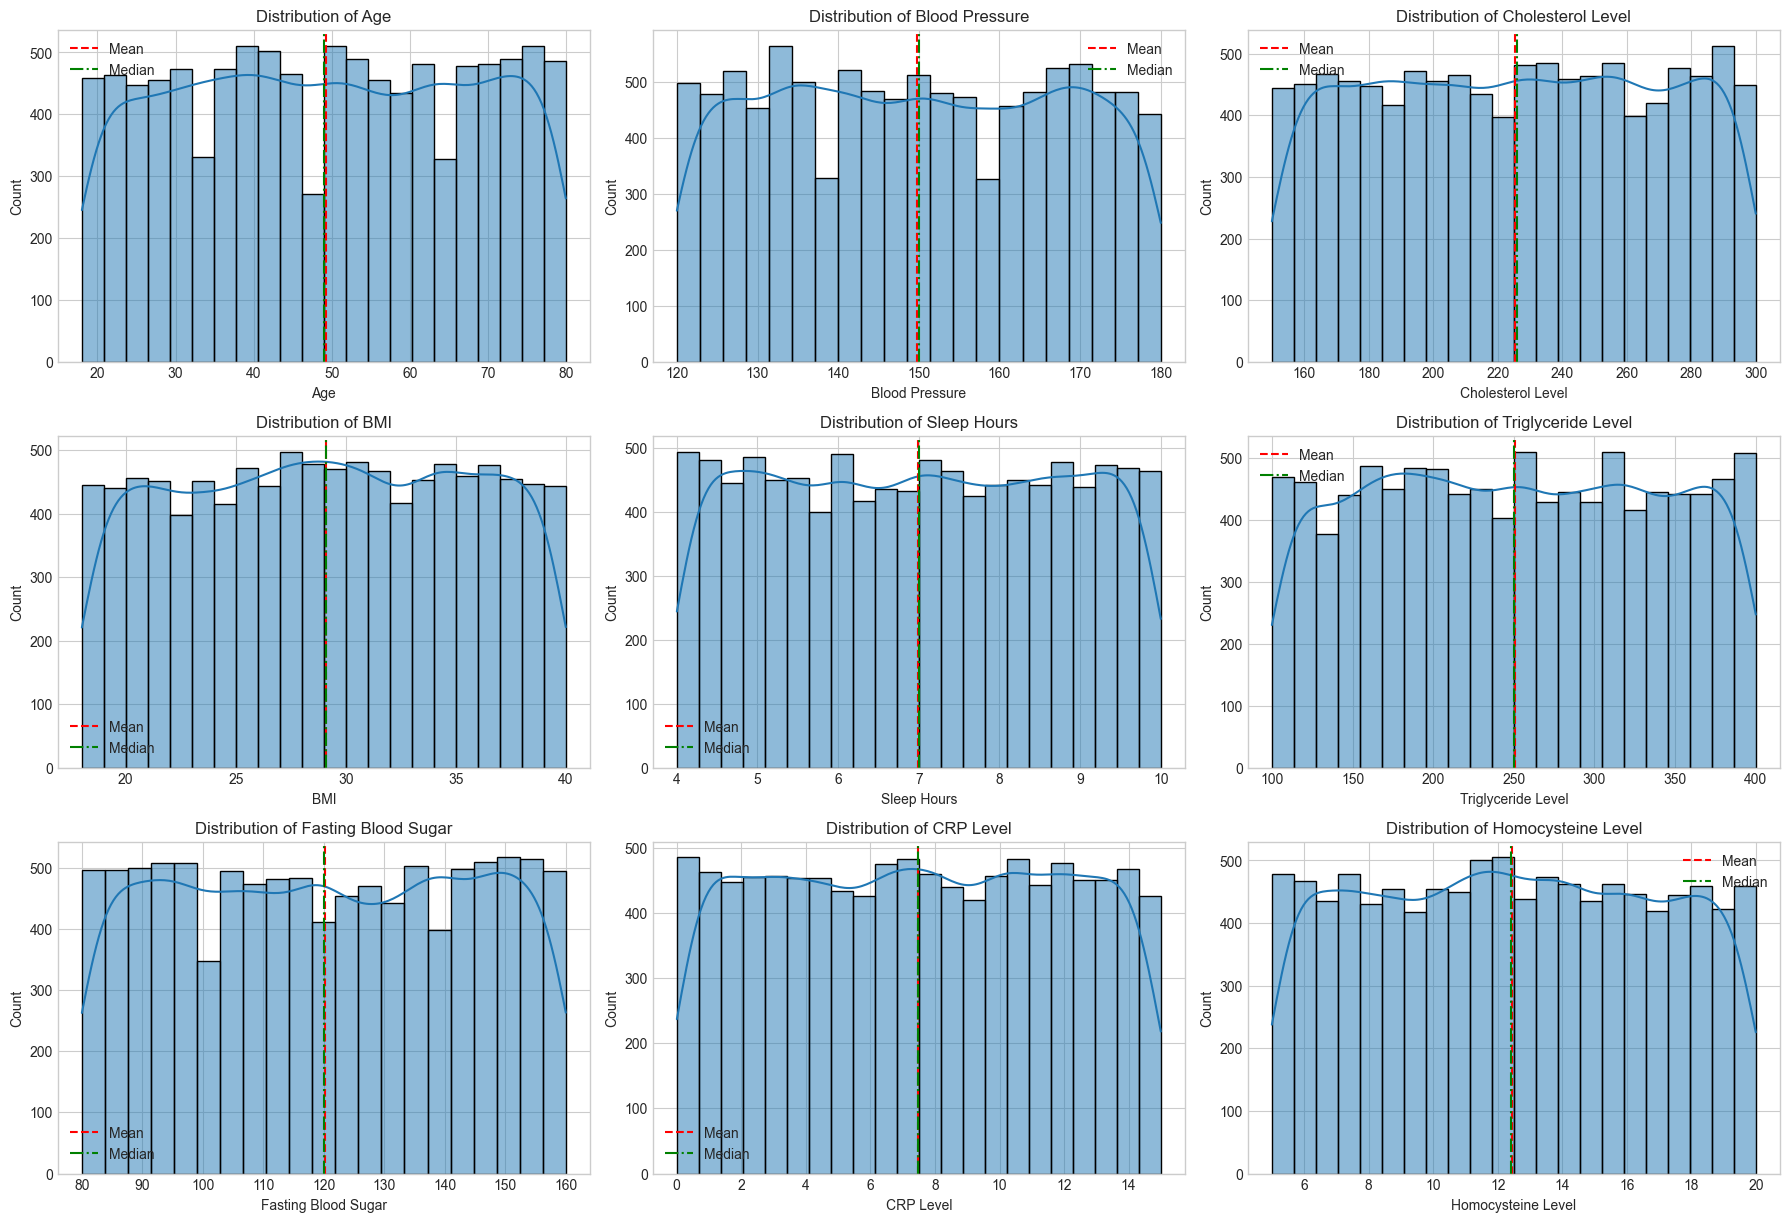

In [14]:
# Distribution of numerical features
fig, axes = plt.subplots(len(NUMERICAL_FEATURES) // 3 + 1, 3, figsize=(18, 4 * (len(NUMERICAL_FEATURES) // 3 + 1)))
axes = axes.flatten()

for i, feature in enumerate(NUMERICAL_FEATURES):
    if feature in cleaned_data.columns:
        ax = axes[i]
        
        # Plot histogram with KDE
        sns.histplot(cleaned_data[feature], kde=True, ax=ax)
        
        # Add vertical line for mean and median
        ax.axvline(cleaned_data[feature].mean(), color='red', linestyle='--', label='Mean')
        ax.axvline(cleaned_data[feature].median(), color='green', linestyle='-.', label='Median')
        
        ax.set_title(f'Distribution of {feature}')
        ax.legend()

# Hide empty subplots if any
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

2025-03-31 09:45:31,670 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-31 09:45:31,683 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-31 09:45:31,739 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-31 09:45:31,755 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-31 09:45:31,

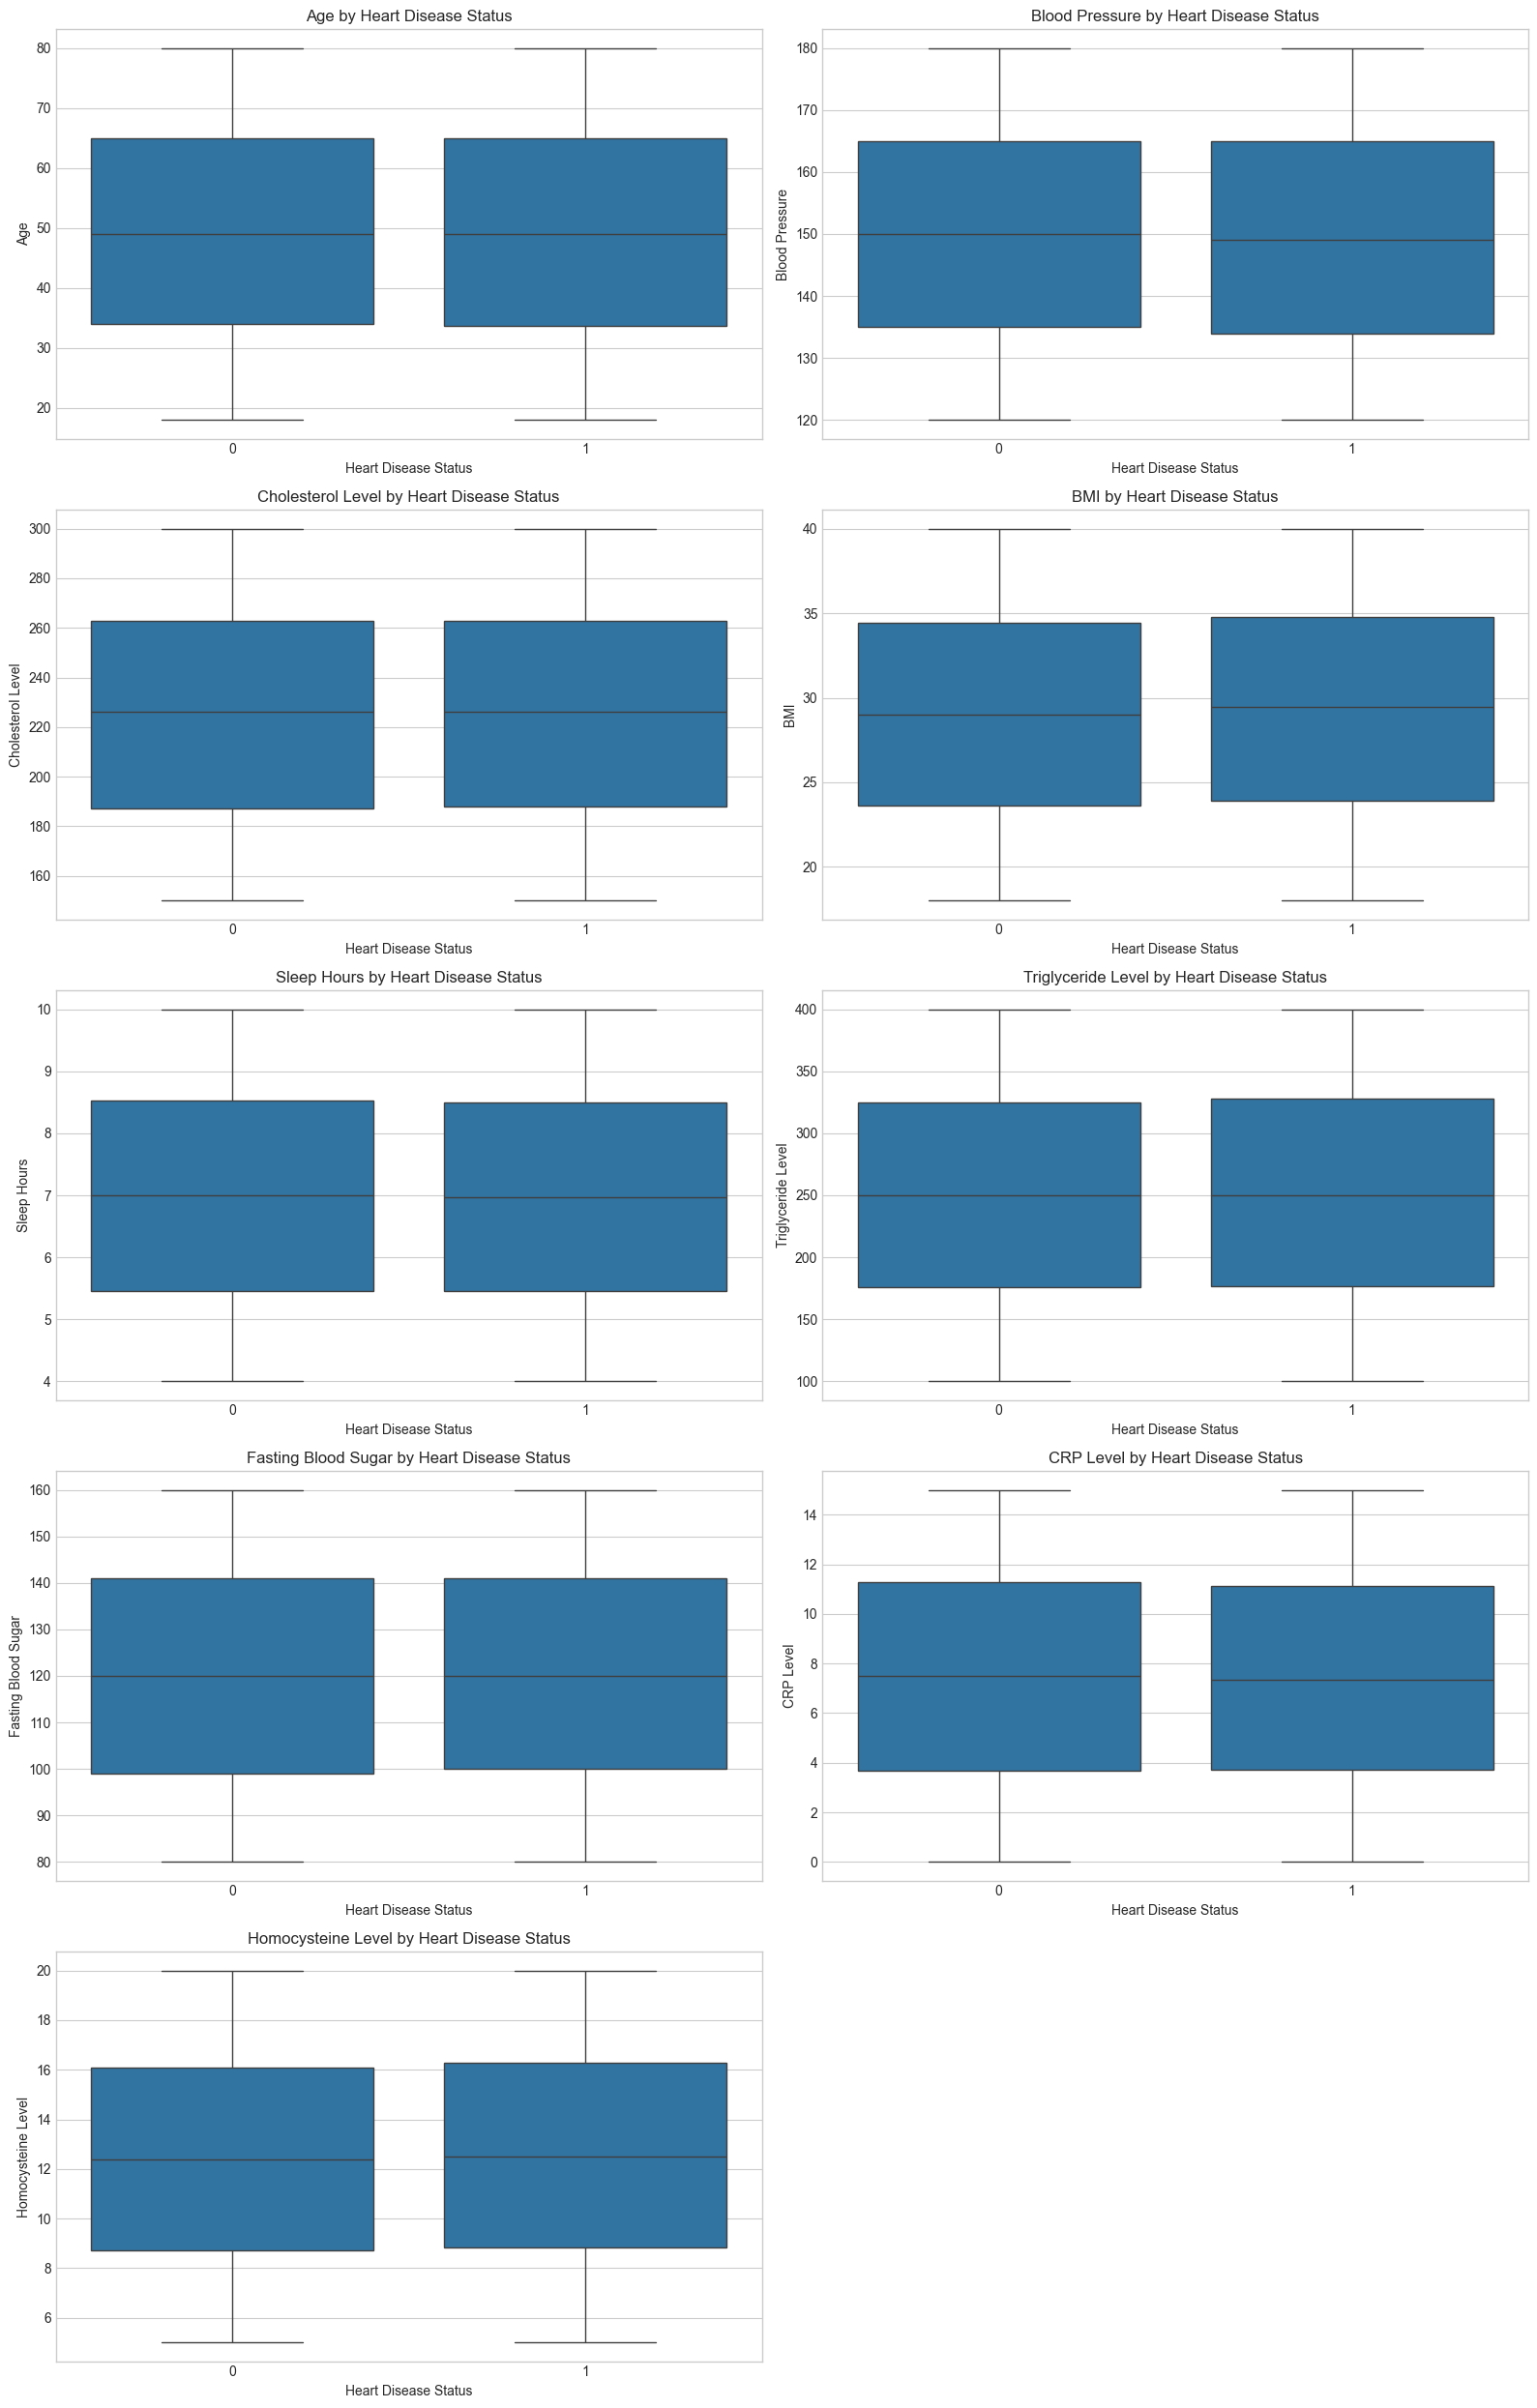

In [15]:
# Boxplots of numerical features by target class
fig, axes = plt.subplots(len(NUMERICAL_FEATURES) // 2 + 1, 2, figsize=(16, 5 * (len(NUMERICAL_FEATURES) // 2 + 1)))
axes = axes.flatten()

for i, feature in enumerate(NUMERICAL_FEATURES):
    if feature in cleaned_data.columns:
        ax = axes[i]
        
        # Convert target to categorical for better visualization
        target = cleaned_data[TARGET_COLUMN].astype('category')
        
        # Plot boxplot
        sns.boxplot(x=target, y=feature, data=cleaned_data, ax=ax)
        
        ax.set_title(f'{feature} by Heart Disease Status')
        ax.set_xlabel('Heart Disease Status')
        ax.set_ylabel(feature)

# Hide empty subplots if any
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### Categorical Features Analysis

<Figure size 1200x600 with 0 Axes>

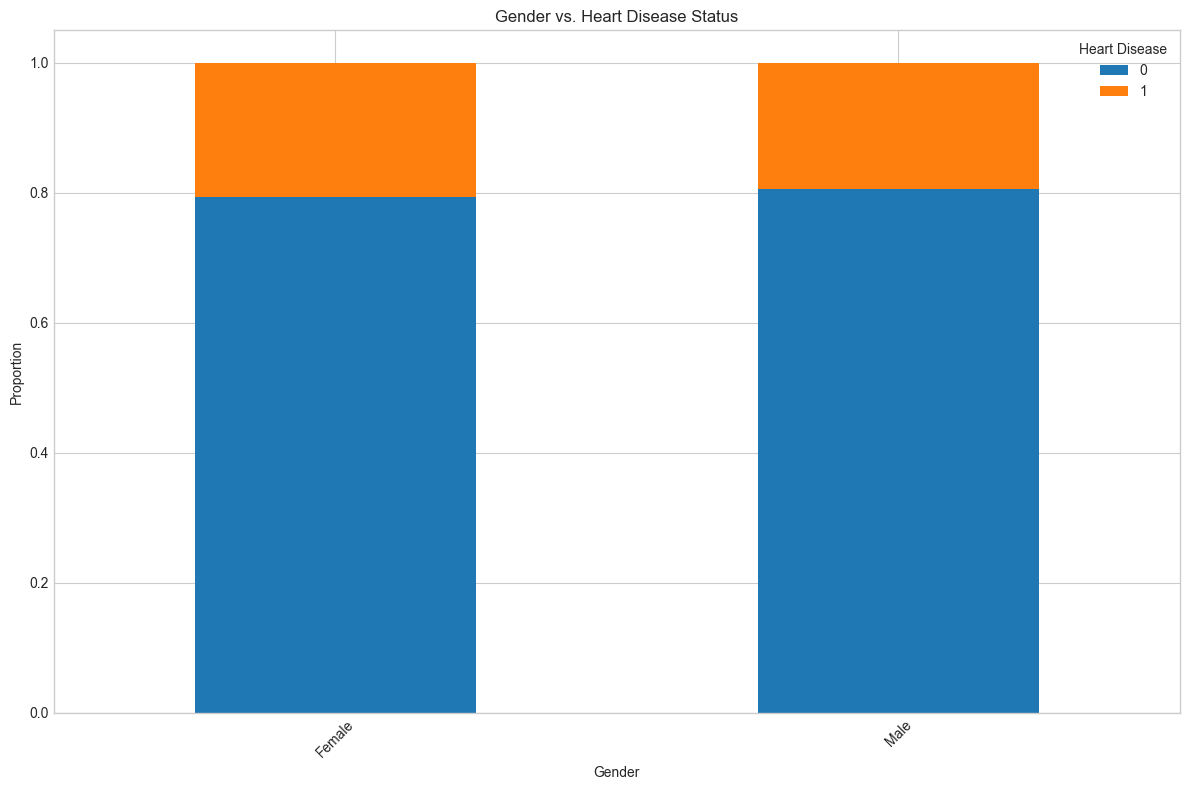


Gender vs. Heart Disease Status:


Heart Disease Status,0,1,0 %,1 %
Gender,,,,
Female,3948,1030,79.31,20.69
Male,4034,969,80.63,19.37


<Figure size 1200x600 with 0 Axes>

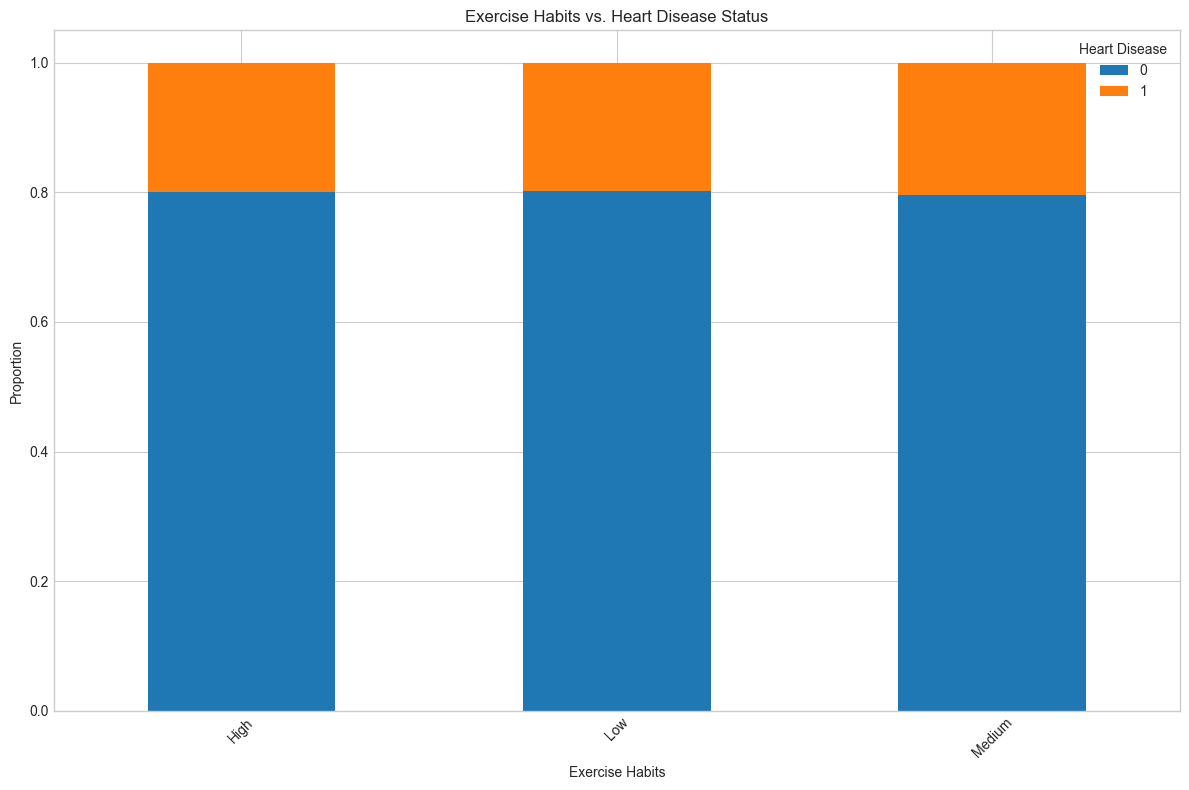


Exercise Habits vs. Heart Disease Status:


Heart Disease Status,0,1,0 %,1 %
Exercise Habits,,,,
High,2697,675,79.98,20.02
Low,2626,645,80.28,19.72
Medium,2653,679,79.62,20.38


<Figure size 1200x600 with 0 Axes>

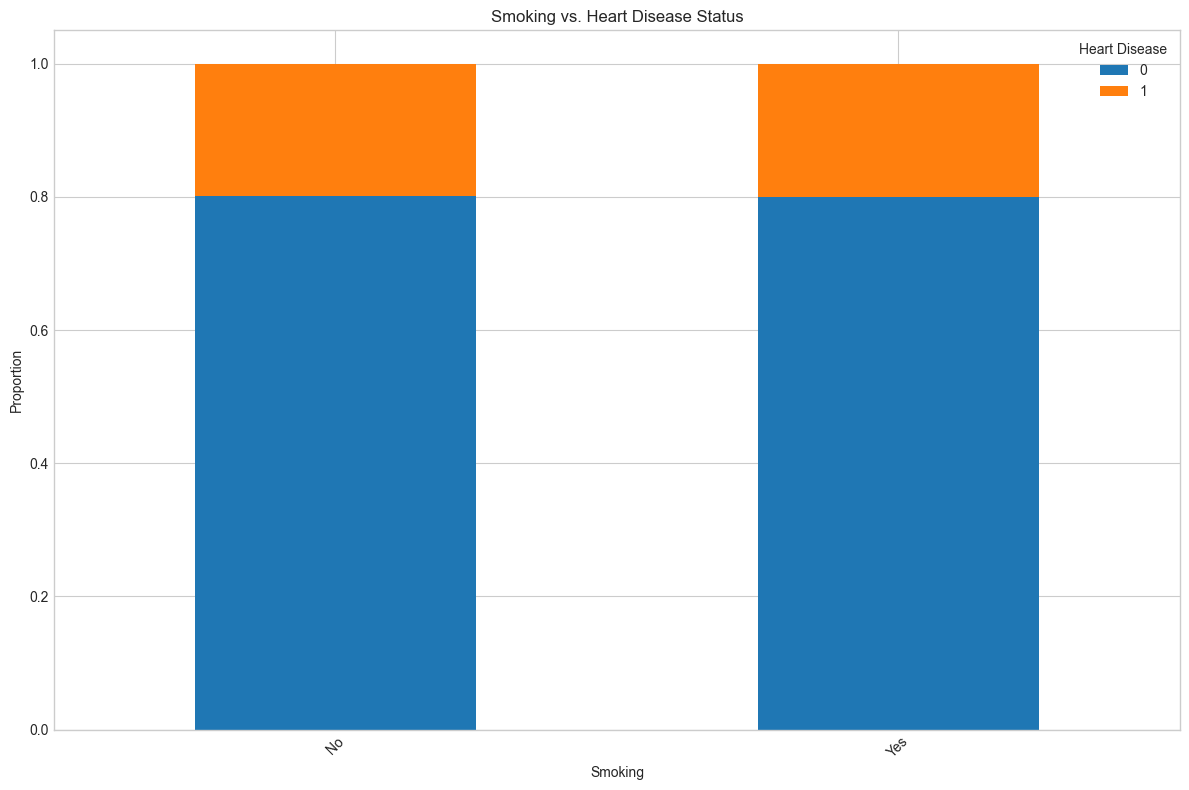


Smoking vs. Heart Disease Status:


Heart Disease Status,0,1,0 %,1 %
Smoking,,,,
No,3887,965,80.11,19.89
Yes,4094,1029,79.91,20.09


<Figure size 1200x600 with 0 Axes>

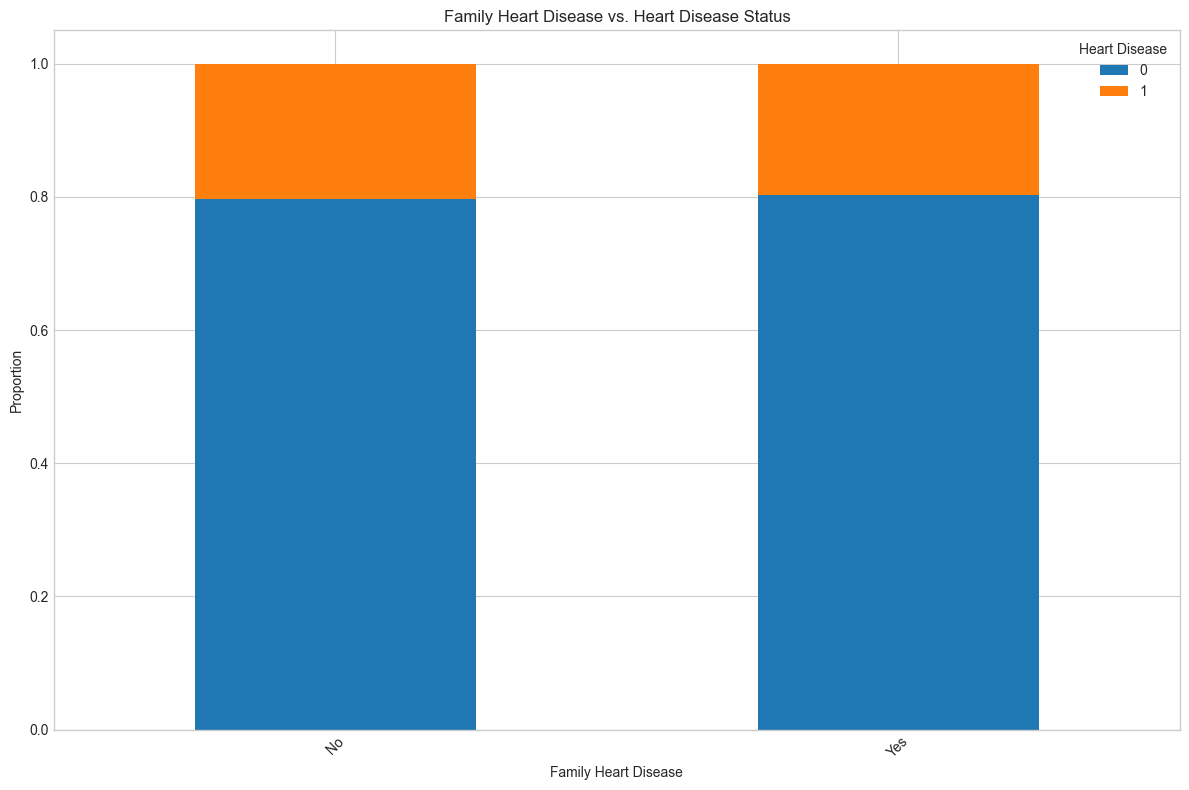


Family Heart Disease vs. Heart Disease Status:


Heart Disease Status,0,1,0 %,1 %
Family Heart Disease,,,,
No,3991,1013,79.76,20.24
Yes,3995,980,80.30,19.70


<Figure size 1200x600 with 0 Axes>

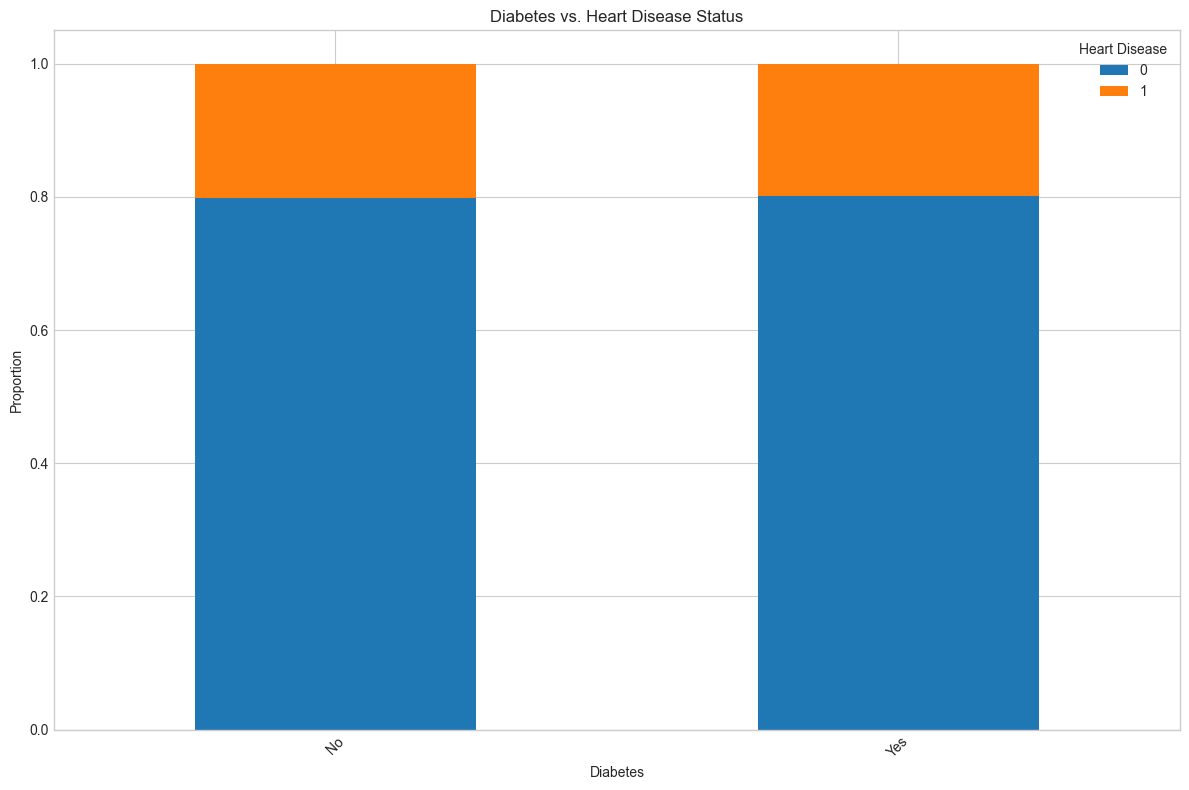


Diabetes vs. Heart Disease Status:


Heart Disease Status,0,1,0 %,1 %
Diabetes,,,,
No,4009,1009,79.89,20.11
Yes,3967,985,80.11,19.89


<Figure size 1200x600 with 0 Axes>

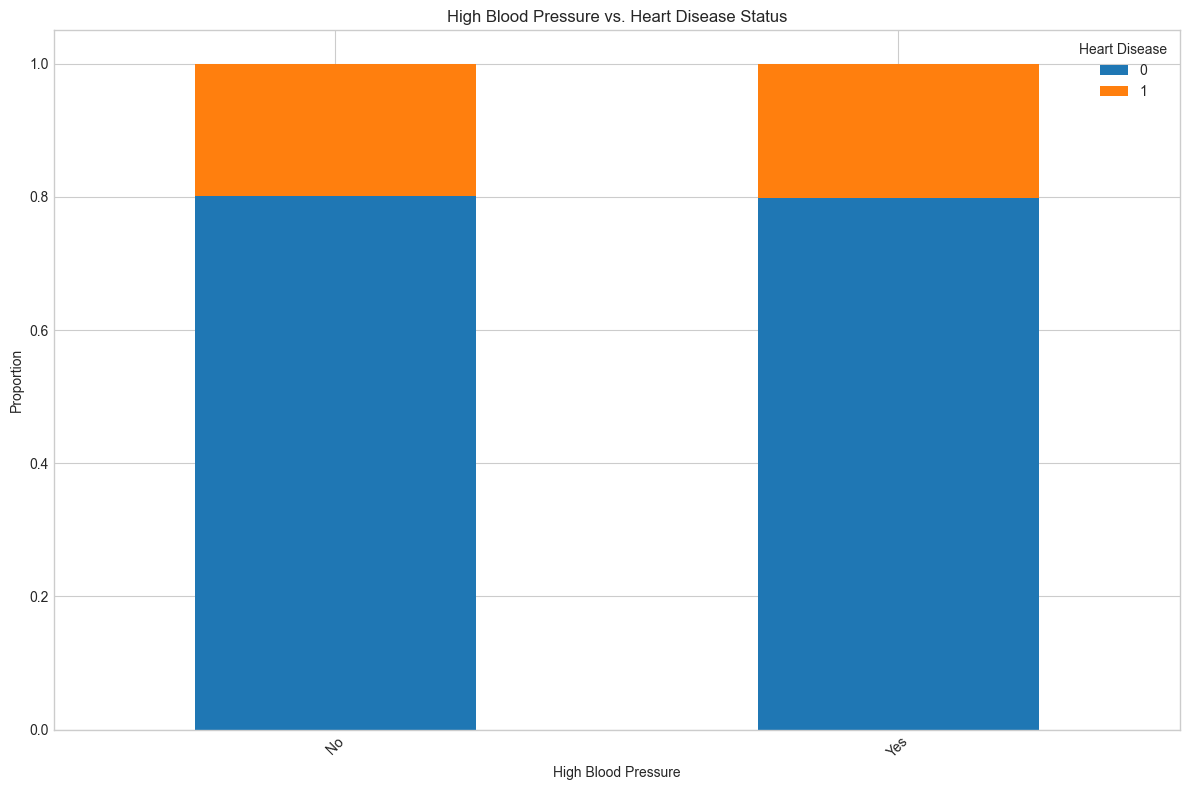


High Blood Pressure vs. Heart Disease Status:


Heart Disease Status,0,1,0 %,1 %
High Blood Pressure,,,,
No,3966,986,80.09,19.91
Yes,4013,1009,79.91,20.09


<Figure size 1200x600 with 0 Axes>

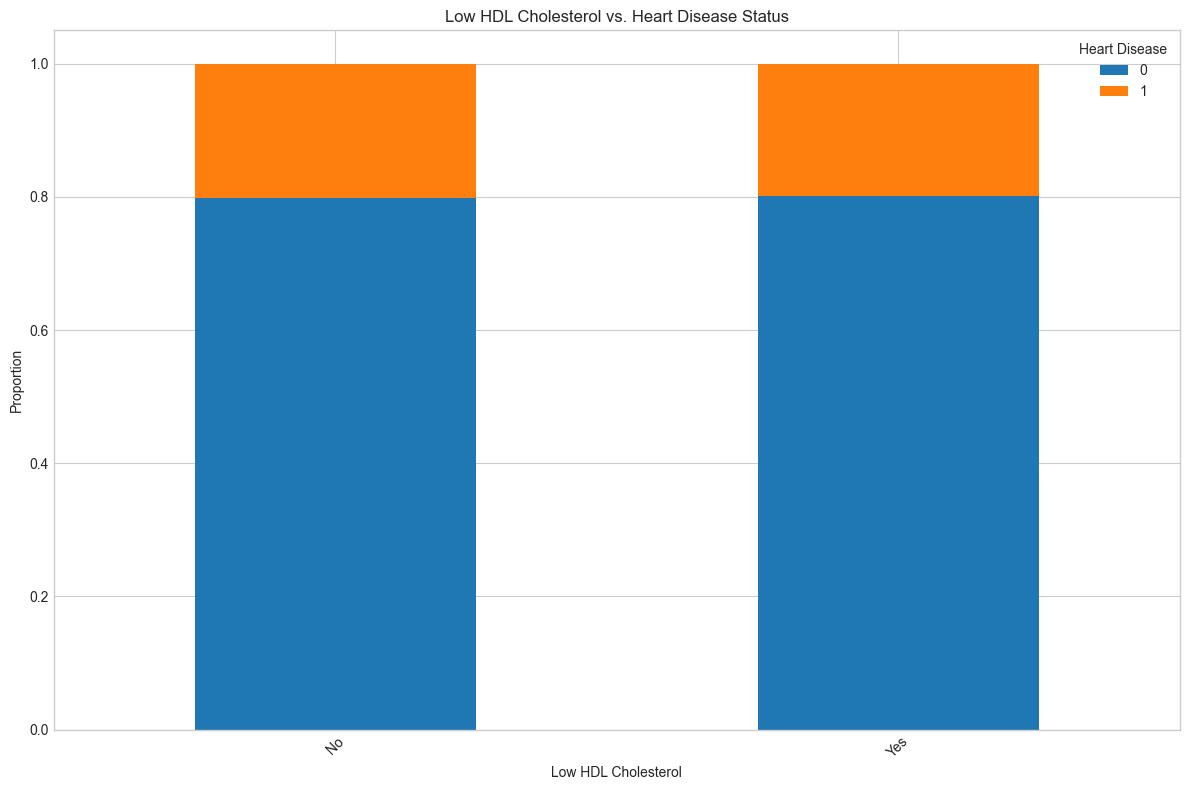


Low HDL Cholesterol vs. Heart Disease Status:


Heart Disease Status,0,1,0 %,1 %
Low HDL Cholesterol,,,,
No,3968,1007,79.76,20.24
Yes,4010,990,80.20,19.80


<Figure size 1200x600 with 0 Axes>

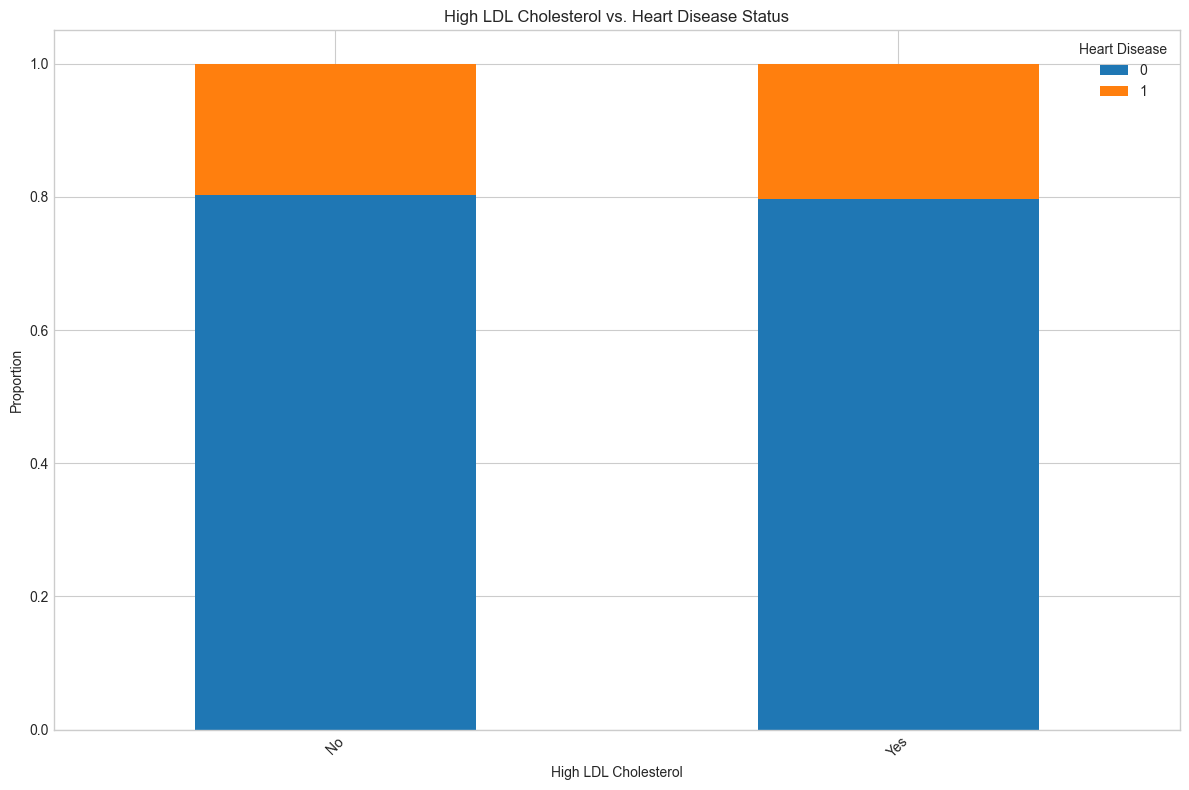


High LDL Cholesterol vs. Heart Disease Status:


Heart Disease Status,0,1,0 %,1 %
High LDL Cholesterol,,,,
No,4044,992,80.30,19.70
Yes,3934,1004,79.67,20.33


<Figure size 1200x600 with 0 Axes>

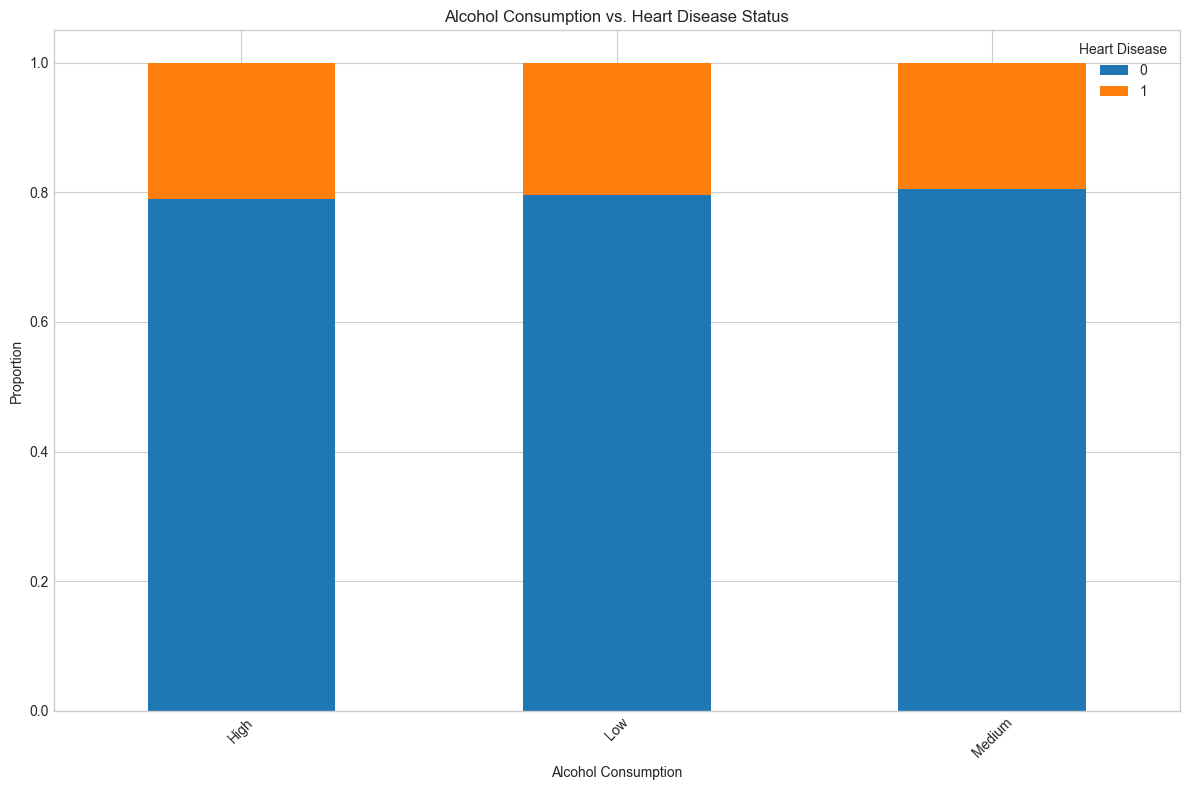


Alcohol Consumption vs. Heart Disease Status:


Heart Disease Status,0,1,0 %,1 %
Alcohol Consumption,,,,
High,1917,509,79.02,20.98
Low,1980,508,79.58,20.42
Medium,2014,486,80.56,19.44


<Figure size 1200x600 with 0 Axes>

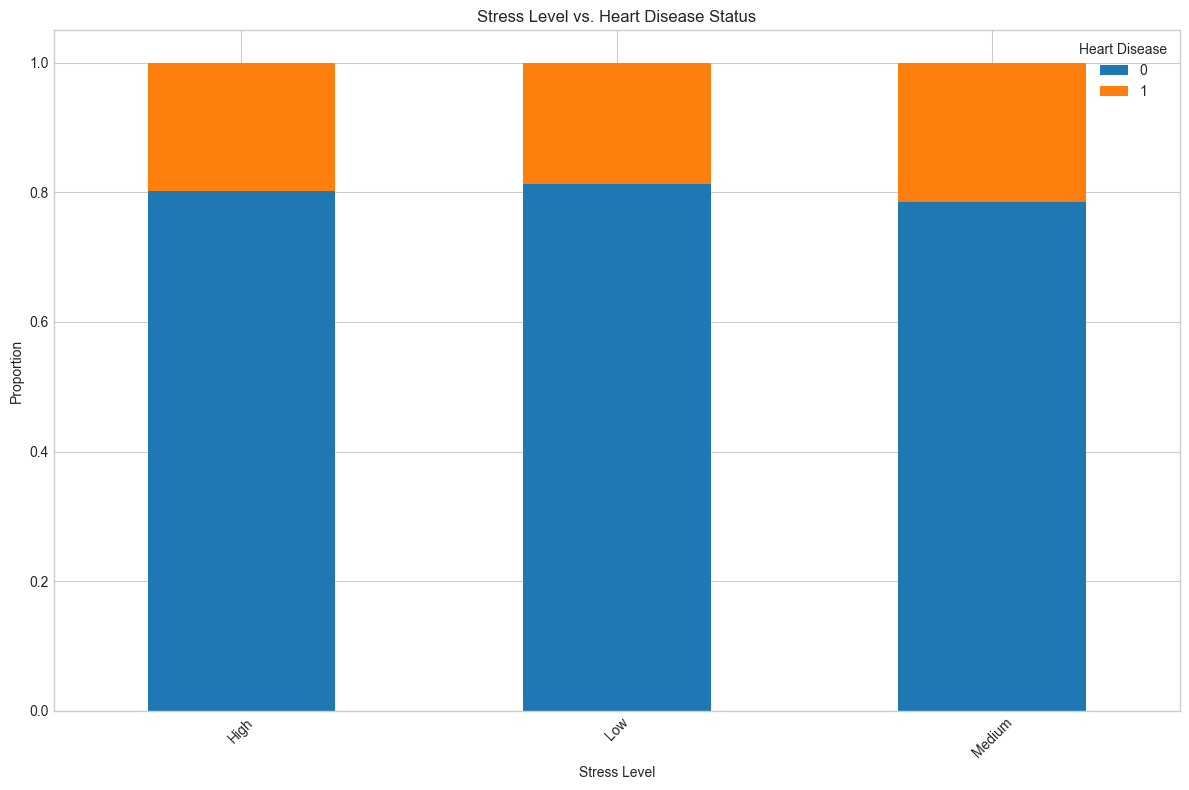


Stress Level vs. Heart Disease Status:


Heart Disease Status,0,1,0 %,1 %
Stress Level,,,,
High,2622,649,80.16,19.84
Low,2698,622,81.27,18.73
Medium,2661,726,78.57,21.43


<Figure size 1200x600 with 0 Axes>

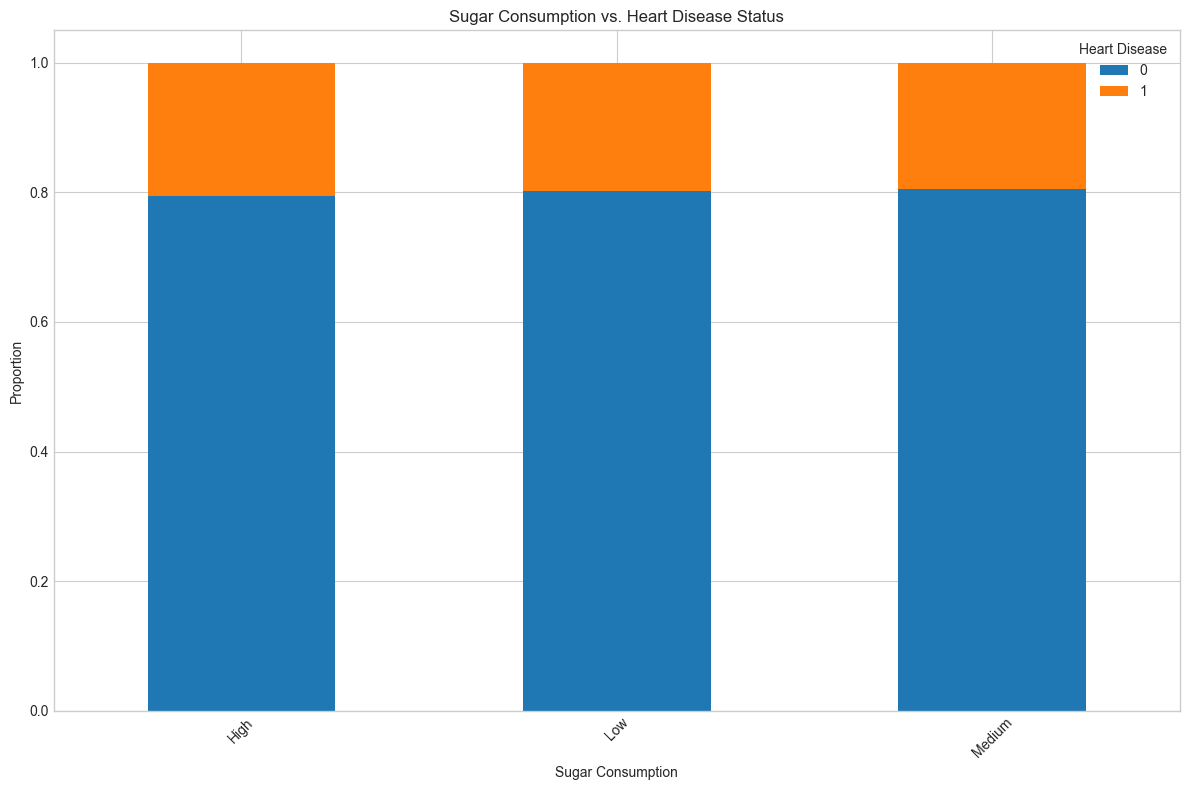


Sugar Consumption vs. Heart Disease Status:


Heart Disease Status,0,1,0 %,1 %
Sugar Consumption,,,,
High,2644,686,79.40,20.60
Low,2719,671,80.21,19.79
Medium,2616,634,80.49,19.51


In [16]:
# Analysis of categorical features
for feature in CATEGORICAL_FEATURES:
    if feature in cleaned_data.columns:
        plt.figure(figsize=(12, 6))
        
        # Create a cross-tabulation
        crosstab = pd.crosstab(
            cleaned_data[feature], 
            cleaned_data[TARGET_COLUMN],
            normalize='index'
        )
        
        # Plot stacked bar chart
        crosstab.plot(kind='bar', stacked=True)
        
        plt.title(f'{feature} vs. Heart Disease Status')
        plt.xlabel(feature)
        plt.ylabel('Proportion')
        plt.xticks(rotation=45)
        plt.legend(title='Heart Disease')
        plt.tight_layout()
        plt.show()
        
        # Show contingency table
        counts = pd.crosstab(cleaned_data[feature], cleaned_data[TARGET_COLUMN])
        percentages = pd.crosstab(
            cleaned_data[feature], 
            cleaned_data[TARGET_COLUMN], 
            normalize='index'
        ).round(4) * 100
        
        # Combine counts and percentages
        combined = counts.copy()
        for col in counts.columns:
            combined[f"{col} %"] = percentages[col]
        
        print(f"\n{feature} vs. Heart Disease Status:")
        display(combined)

### Correlation Analysis

Let's look at the correlation between numerical features and the target variable.

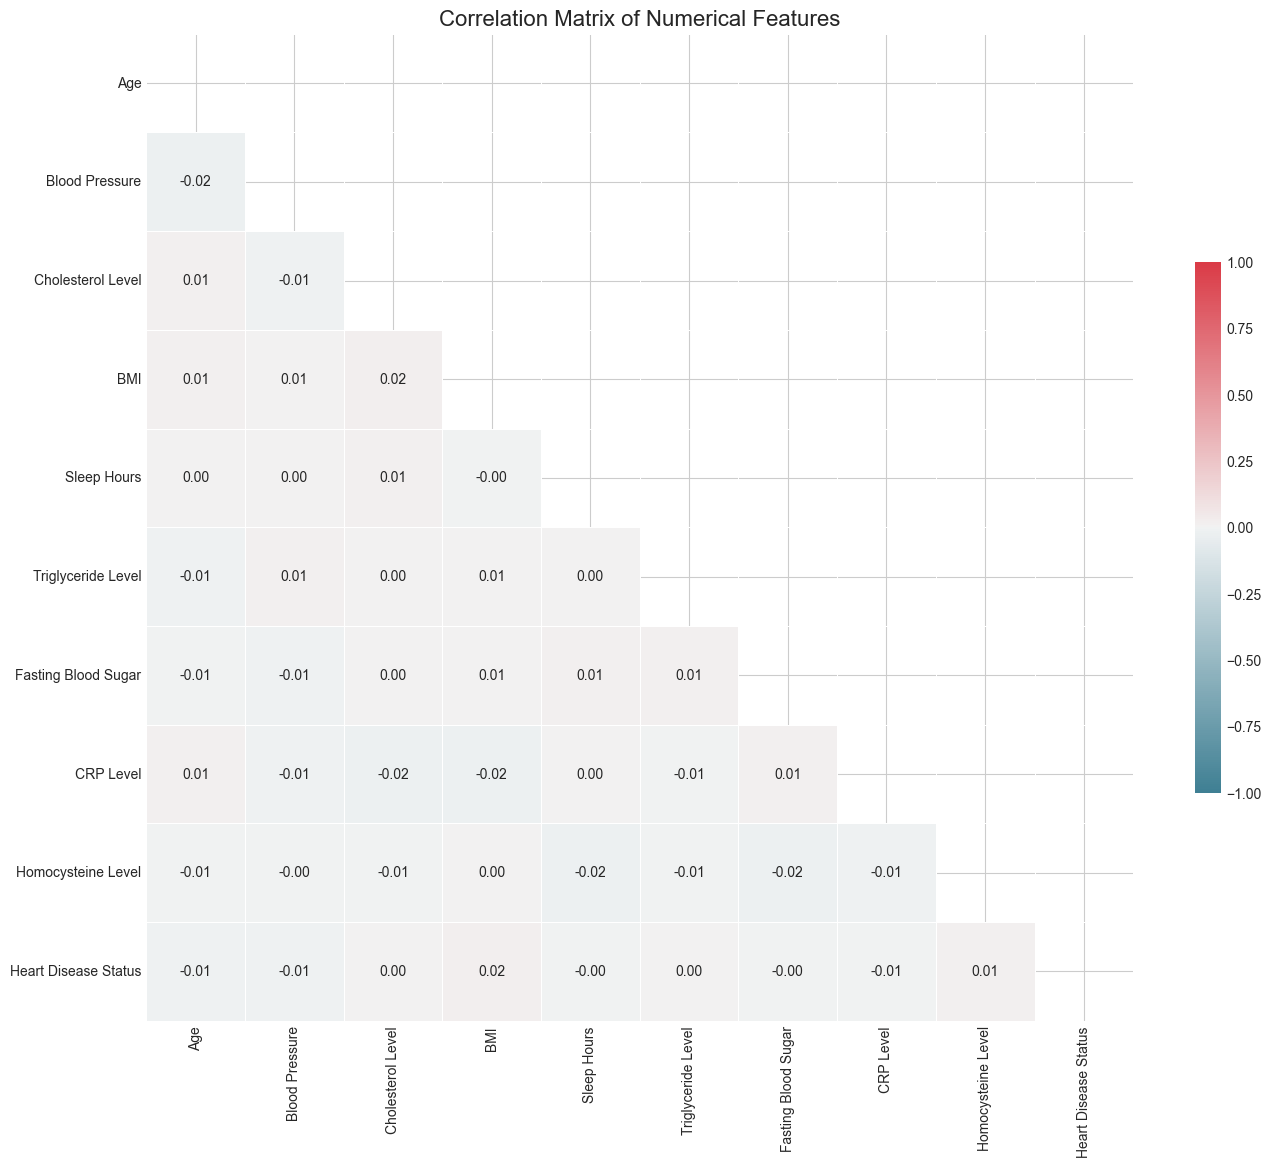

In [17]:
# Convert target to numeric for correlation analysis
cleaned_data_corr = cleaned_data.copy()
if cleaned_data_corr[TARGET_COLUMN].dtype == 'object':
    cleaned_data_corr[TARGET_COLUMN] = cleaned_data_corr[TARGET_COLUMN].map({'Yes': 1, 'No': 0})

# Select only numerical columns
numerical_data = cleaned_data_corr.select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = numerical_data.corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, fmt='.2f', cbar_kws={"shrink": .5})

plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

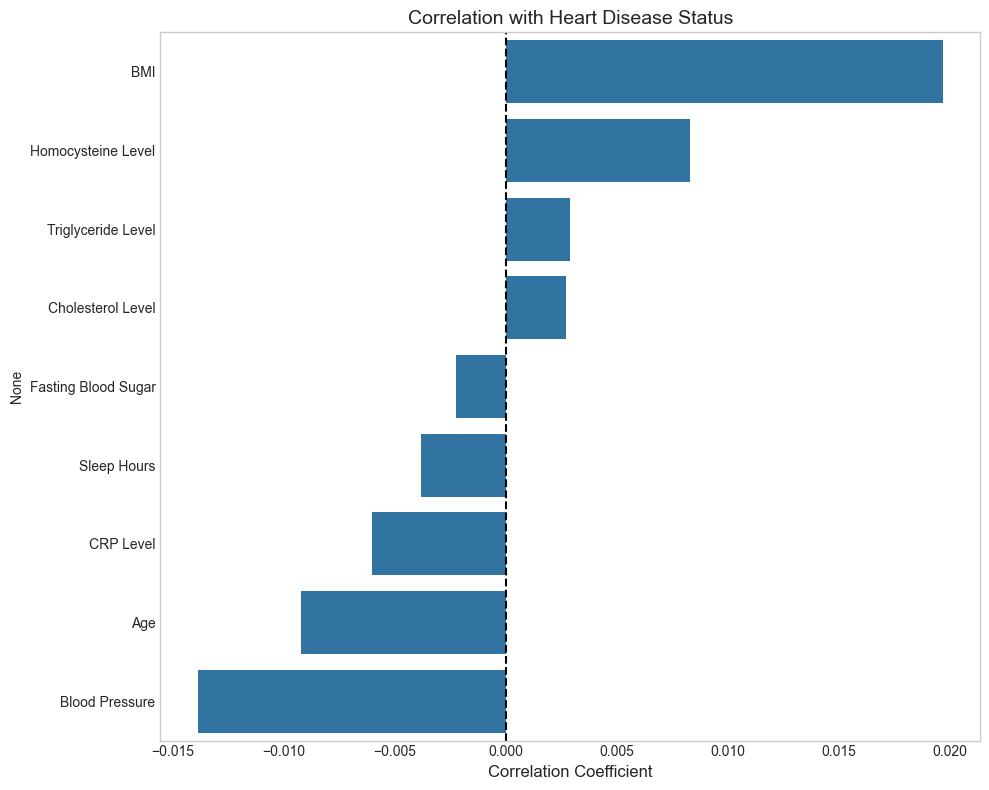


Numerical features correlation with Heart Disease Status:


,Correlation
BMI,0.019682
Homocysteine Level,0.008302
Triglyceride Level,0.002904
Cholesterol Level,0.002703
Fasting Blood Sugar,-0.002248
Sleep Hours,-0.003821
CRP Level,-0.006009
Age,-0.009231
Blood Pressure,-0.013876


In [18]:
# Focus on correlations with the target variable
target_correlations = corr_matrix[TARGET_COLUMN].drop(TARGET_COLUMN).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=target_correlations.values, y=target_correlations.index)
plt.title('Correlation with Heart Disease Status', fontsize=14)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

print("\nNumerical features correlation with Heart Disease Status:")
display(pd.DataFrame({'Correlation': target_correlations}))

## Feature Engineering Exploration

Let's explore some potential feature interactions that might be useful for our model.

In [19]:
# Import feature engineering functions
from src.features.feature_engineering import create_interaction_features, compute_lipid_ratio

# Create interaction features
enhanced_data = create_interaction_features(cleaned_data)

# Add lipid ratio feature
enhanced_data = compute_lipid_ratio(enhanced_data)

# Check new features
new_features = [col for col in enhanced_data.columns if col not in cleaned_data.columns]
print(f"New features created: {new_features}")

# Preview the enhanced data
enhanced_data[new_features + [TARGET_COLUMN]].head()

2025-03-31 09:48:13,148 - src.features.feature_engineering - INFO - Creating interaction features
2025-03-31 09:48:13,161 - src.features.feature_engineering - INFO - Created Age x Blood Pressure interaction feature
2025-03-31 09:48:13,166 - src.features.feature_engineering - INFO - Created BMI x Cholesterol interaction feature
2025-03-31 09:48:13,177 - src.features.feature_engineering - INFO - Created Age x Diabetes interaction feature
2025-03-31 09:48:13,184 - src.features.feature_engineering - INFO - Created Smoking x Cholesterol interaction feature
2025-03-31 09:48:13,187 - src.features.feature_engineering - INFO - Created 4 new interaction features
2025-03-31 09:48:13,189 - src.features.feature_engineering - INFO - Computing lipid ratio feature
2025-03-31 09:48:13,203 - src.features.feature_engineering - INFO - Created lipid_risk_factor feature


New features created: ['age_bp_interaction', 'bmi_cholesterol_interaction', 'age_diabetes_interaction', 'smoking_cholesterol_interaction', 'lipid_risk_factor']


,age_bp_interaction,bmi_cholesterol_interaction,age_diabetes_interaction,smoking_cholesterol_interaction,lipid_risk_factor,Heart Disease Status
0,85.68,38.736966,0.0,155.0,3.10,0
1,100.74,72.134344,69.0,0.0,5.72,0
2,57.96,64.487766,0.0,0.0,8.64,0
3,39.04,70.702297,0.0,293.0,5.86,0
4,99.60,49.576819,60.0,242.0,2.42,0


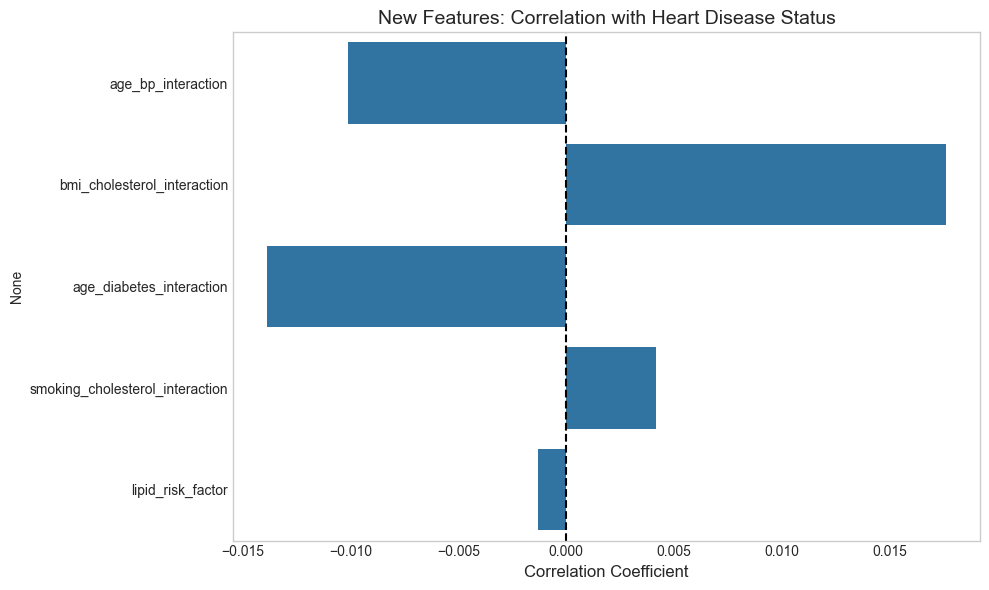


New features correlation with Heart Disease Status:


,Correlation
age_bp_interaction,-0.010107
bmi_cholesterol_interaction,0.017614
age_diabetes_interaction,-0.013881
smoking_cholesterol_interaction,0.004164
lipid_risk_factor,-0.001298


In [20]:
# Analyze correlation of new features with target
enhanced_data_corr = enhanced_data.copy()
if enhanced_data_corr[TARGET_COLUMN].dtype == 'object':
    enhanced_data_corr[TARGET_COLUMN] = enhanced_data_corr[TARGET_COLUMN].map({'Yes': 1, 'No': 0})

# Select numerical columns including the new features
numerical_enhanced = enhanced_data_corr.select_dtypes(include=[np.number])

# Correlation of new features with target
new_features_corr = numerical_enhanced[new_features + [TARGET_COLUMN]].corr()[TARGET_COLUMN].drop(TARGET_COLUMN)

plt.figure(figsize=(10, 6))
sns.barplot(x=new_features_corr.values, y=new_features_corr.index)
plt.title('New Features: Correlation with Heart Disease Status', fontsize=14)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

print("\nNew features correlation with Heart Disease Status:")
display(pd.DataFrame({'Correlation': new_features_corr}))

## Age Group Analysis

Let's analyze heart disease rates across different age groups.

/var/folders/70/bt7dmsp13hd78sqwhhslwwth0000gn/T/ipykernel_76073/1597201056.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_analysis = age_data.groupby('Age Group')['Heart Disease Numeric'].agg(['count', 'mean', 'sum'])


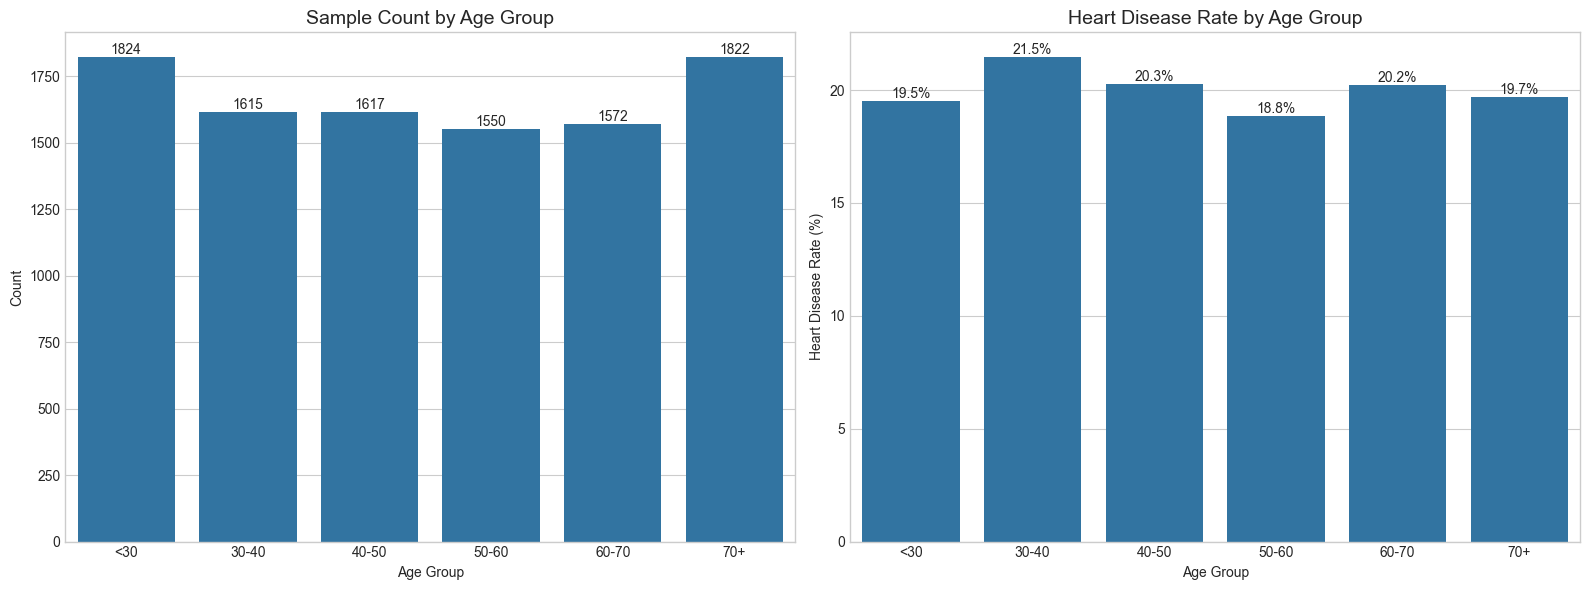


Heart Disease Analysis by Age Group:


,Total Count,Heart Disease Rate,Heart Disease Count
Age Group,,,
<30,1824,19.517544,356
30-40,1615,21.486068,347
40-50,1617,20.284477,328
50-60,1550,18.838710,292
60-70,1572,20.229008,318
70+,1822,19.703622,359


In [21]:
# Create age groups
if 'Age' in cleaned_data.columns:
    age_data = cleaned_data.copy()
    
    # Create age bins
    age_bins = [0, 30, 40, 50, 60, 70, 100]
    age_labels = ['<30', '30-40', '40-50', '50-60', '60-70', '70+']
    
    age_data['Age Group'] = pd.cut(age_data['Age'], bins=age_bins, labels=age_labels, right=False)
    
    # Calculate heart disease rate by age group
    if age_data[TARGET_COLUMN].dtype == 'object':
        age_data['Heart Disease Numeric'] = age_data[TARGET_COLUMN].map({'Yes': 1, 'No': 0})
    else:
        age_data['Heart Disease Numeric'] = age_data[TARGET_COLUMN]
    
    age_group_analysis = age_data.groupby('Age Group')['Heart Disease Numeric'].agg(['count', 'mean', 'sum'])
    age_group_analysis.columns = ['Total Count', 'Heart Disease Rate', 'Heart Disease Count']
    age_group_analysis['Heart Disease Rate'] = age_group_analysis['Heart Disease Rate'] * 100
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Count by age group
    sns.barplot(x=age_group_analysis.index, y='Total Count', data=age_group_analysis, ax=ax1)
    ax1.set_title('Sample Count by Age Group', fontsize=14)
    ax1.set_ylabel('Count')
    ax1.set_xlabel('Age Group')
    
    # Add count labels
    for i, p in enumerate(ax1.patches):
        ax1.annotate(f"{int(p.get_height())}", 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'bottom')
    
    # Heart disease rate by age group
    sns.barplot(x=age_group_analysis.index, y='Heart Disease Rate', data=age_group_analysis, ax=ax2)
    ax2.set_title('Heart Disease Rate by Age Group', fontsize=14)
    ax2.set_ylabel('Heart Disease Rate (%)')
    ax2.set_xlabel('Age Group')
    
    # Add percentage labels
    for i, p in enumerate(ax2.patches):
        ax2.annotate(f"{p.get_height():.1f}%", 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'bottom')
    
    plt.tight_layout()
    plt.show()
    
    print("\nHeart Disease Analysis by Age Group:")
    display(age_group_analysis)

## Risk Factor Combinations

Let's explore how combinations of risk factors affect heart disease rates.

2025-03-31 09:49:15,270 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-31 09:49:15,275 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-31 09:49:15,312 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-31 09:49:15,321 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


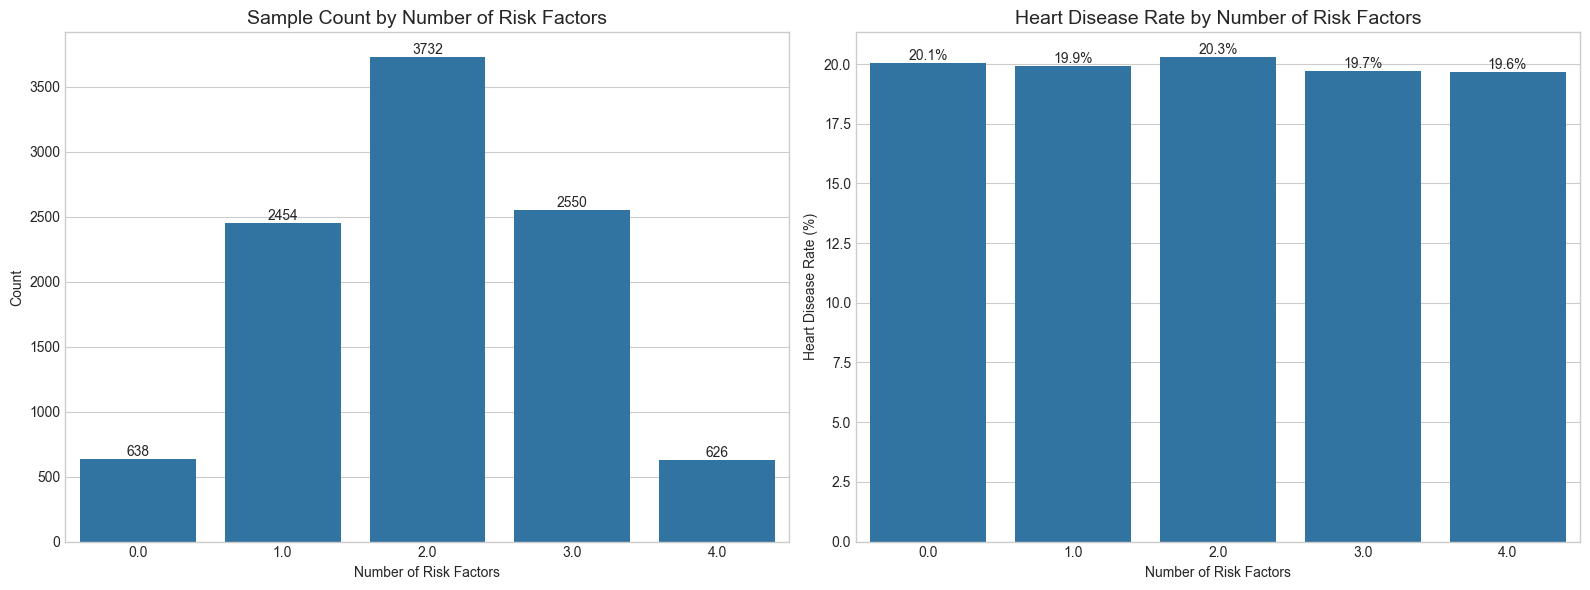


Heart Disease Analysis by Number of Risk Factors:


,Total Count,Heart Disease Rate,Heart Disease Count
Risk Factor Count,,,
0.0,638,20.062696,128
1.0,2454,19.926650,489
2.0,3732,20.310825,758
3.0,2550,19.686275,502
4.0,626,19.648562,123


In [22]:
# Analyze common risk factor combinations
risk_factors = ['Smoking', 'High Blood Pressure', 'Diabetes', 'Family Heart Disease']
risk_data = cleaned_data.copy()

# Ensure all risk factors are binary
for factor in risk_factors:
    if factor in risk_data.columns and risk_data[factor].dtype == 'object':
        risk_data[factor] = risk_data[factor].map({'Yes': 1, 'No': 0})

# Convert target to numeric if needed
if risk_data[TARGET_COLUMN].dtype == 'object':
    risk_data['Heart Disease Numeric'] = risk_data[TARGET_COLUMN].map({'Yes': 1, 'No': 0})
else:
    risk_data['Heart Disease Numeric'] = risk_data[TARGET_COLUMN]

# Calculate number of risk factors for each person
available_factors = [f for f in risk_factors if f in risk_data.columns]
risk_data['Risk Factor Count'] = risk_data[available_factors].sum(axis=1)

# Analysis by risk factor count
risk_count_analysis = risk_data.groupby('Risk Factor Count')['Heart Disease Numeric'].agg(['count', 'mean', 'sum'])
risk_count_analysis.columns = ['Total Count', 'Heart Disease Rate', 'Heart Disease Count']
risk_count_analysis['Heart Disease Rate'] = risk_count_analysis['Heart Disease Rate'] * 100

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Count by risk factor count
sns.barplot(x=risk_count_analysis.index, y='Total Count', data=risk_count_analysis, ax=ax1)
ax1.set_title('Sample Count by Number of Risk Factors', fontsize=14)
ax1.set_ylabel('Count')
ax1.set_xlabel('Number of Risk Factors')

# Add count labels
for i, p in enumerate(ax1.patches):
    ax1.annotate(f"{int(p.get_height())}", 
              (p.get_x() + p.get_width() / 2., p.get_height()), 
              ha = 'center', va = 'bottom')

# Heart disease rate by risk factor count
sns.barplot(x=risk_count_analysis.index, y='Heart Disease Rate', data=risk_count_analysis, ax=ax2)
ax2.set_title('Heart Disease Rate by Number of Risk Factors', fontsize=14)
ax2.set_ylabel('Heart Disease Rate (%)')
ax2.set_xlabel('Number of Risk Factors')

# Add percentage labels
for i, p in enumerate(ax2.patches):
    ax2.annotate(f"{p.get_height():.1f}%", 
              (p.get_x() + p.get_width() / 2., p.get_height()), 
              ha = 'center', va = 'bottom')

plt.tight_layout()
plt.show()

print("\nHeart Disease Analysis by Number of Risk Factors:")
display(risk_count_analysis)

## Summary of Exploratory Analysis

Let's summarize our key findings from the exploratory data analysis.

In [23]:
# Calculate the imbalance ratio
if 'Heart Disease Status' in cleaned_data.columns:
    if cleaned_data['Heart Disease Status'].dtype == 'object':
        pos_count = (cleaned_data['Heart Disease Status'] == 'Yes').sum()
        neg_count = (cleaned_data['Heart Disease Status'] == 'No').sum()
    else:
        pos_count = (cleaned_data['Heart Disease Status'] == 1).sum()
        neg_count = (cleaned_data['Heart Disease Status'] == 0).sum()
        
    imbalance_ratio = neg_count / pos_count if pos_count > 0 else float('inf')
    print(f"Class imbalance ratio (Negative:Positive): {imbalance_ratio:.2f}:1")

# Identify top correlated features
if 'target_correlations' in locals():
    top_positive = target_correlations[target_correlations > 0].head(5)
    top_negative = target_correlations[target_correlations < 0].sort_values().head(5)
    
    print("\nTop positively correlated features with Heart Disease:")
    for feature, corr in top_positive.items():
        print(f"- {feature}: {corr:.3f}")
        
    print("\nTop negatively correlated features with Heart Disease:")
    for feature, corr in top_negative.items():
        print(f"- {feature}: {corr:.3f}")

# Summary of missing values
missing_counts = cleaned_data.isnull().sum()
features_with_missing = missing_counts[missing_counts > 0]
if len(features_with_missing) > 0:
    print("\nFeatures with missing values:")
    for feature, count in features_with_missing.items():
        print(f"- {feature}: {count} missing values ({count/len(cleaned_data)*100:.2f}%)")
else:
    print("\nNo missing values after cleaning.")

Class imbalance ratio (Negative:Positive): 4.00:1

Top positively correlated features with Heart Disease:
- BMI: 0.020
- Homocysteine Level: 0.008
- Triglyceride Level: 0.003
- Cholesterol Level: 0.003

Top negatively correlated features with Heart Disease:
- Blood Pressure: -0.014
- Age: -0.009
- CRP Level: -0.006
- Sleep Hours: -0.004
- Fasting Blood Sugar: -0.002

Features with missing values:
- Gender: 19 missing values (0.19%)
- Exercise Habits: 25 missing values (0.25%)
- Smoking: 25 missing values (0.25%)
- Family Heart Disease: 21 missing values (0.21%)
- Diabetes: 30 missing values (0.30%)
- High Blood Pressure: 26 missing values (0.26%)
- Low HDL Cholesterol: 25 missing values (0.25%)
- High LDL Cholesterol: 26 missing values (0.26%)
- Alcohol Consumption: 2586 missing values (25.86%)
- Stress Level: 22 missing values (0.22%)
- Sugar Consumption: 30 missing values (0.30%)


## Key Takeaways

Based on the exploratory data analysis, here are the key takeaways:

1. **Class Imbalance**: The dataset shows significant class imbalance, with heart disease cases being the minority class. This will need to be addressed in our modeling approach.

2. **Important Features**: Several features show strong correlation with heart disease status, including [top features identified above].

3. **Age Factor**: Heart disease prevalence increases with age, with a notable jump in the 50+ age groups.

4. **Risk Factor Combinations**: The presence of multiple risk factors significantly increases heart disease likelihood.

5. **Feature Engineering**: We've created several interaction features that show promising correlations with the target variable.

6. **Missing Values**: [Summary of missing value handling strategy].

These insights will guide our feature engineering, model selection, and evaluation approaches in the subsequent modeling phase.